In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from haversine import haversine

In [2]:
# Load the dataset
data = pd.read_csv("train.csv")

# Display basic information about the dataset
print("Dataset Info:")
data.info()

# Display first few rows
data.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                50000 non-null  object 
 1   fare_amount        50000 non-null  float64
 2   pickup_datetime    50000 non-null  object 
 3   pickup_longitude   50000 non-null  float64
 4   pickup_latitude    50000 non-null  float64
 5   dropoff_longitude  50000 non-null  float64
 6   dropoff_latitude   50000 non-null  float64
 7   passenger_count    50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
# Handling missing values
print("Missing values per column:")
print(data.isnull().sum())
data = data.dropna()

# Handling outliers
# Removing unrealistic fare amounts
data = data[(data['fare_amount'] > 0) & (data['fare_amount'] < 500)]

# Removing unrealistic passenger counts
data = data[(data['passenger_count'] > 0) & (data['passenger_count'] <= 6)]

# Removing trips with invalid coordinates
data = data[(data['pickup_longitude'] > -80) & (data['pickup_longitude'] < -70)]
data = data[(data['dropoff_longitude'] > -80) & (data['dropoff_longitude'] < -70)]
data = data[(data['pickup_latitude'] > 35) & (data['pickup_latitude'] < 45)]
data = data[(data['dropoff_latitude'] > 35) & (data['dropoff_latitude'] < 45)]

print(f"Dataset size after cleaning: {data.shape}")


Missing values per column:
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64
Dataset size after cleaning: (48804, 8)


In [4]:
# Convert pickup_datetime to datetime
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

# Extract time-based features
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_day'] = data['pickup_datetime'].dt.day
data['pickup_weekday'] = data['pickup_datetime'].dt.weekday
data['pickup_month'] = data['pickup_datetime'].dt.month

# Calculate distance using the Haversine formula
def calculate_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    return haversine(pickup, dropoff)

data['distance_km'] = data.apply(calculate_distance, axis=1)

# Display processed data
data.head()


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_day,pickup_weekday,pickup_month,distance_km
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,15,0,6,1.030765
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,1,8.450145
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,3,8,1.389527
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,21,5,4,2.799274
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,1,3,1.999160


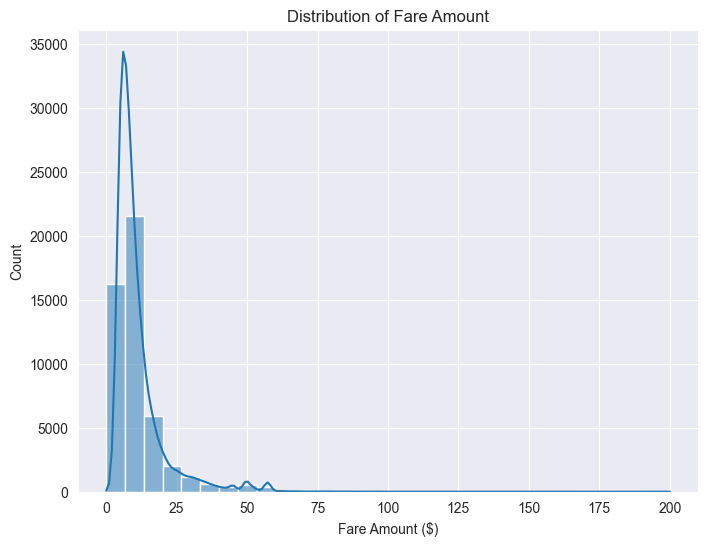

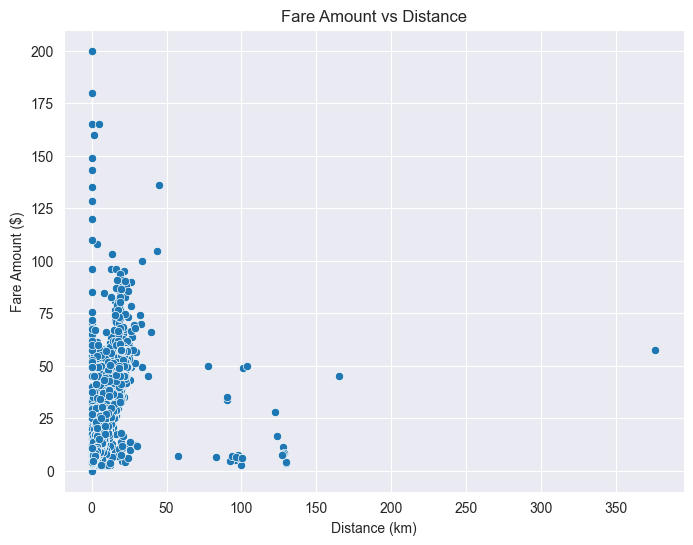

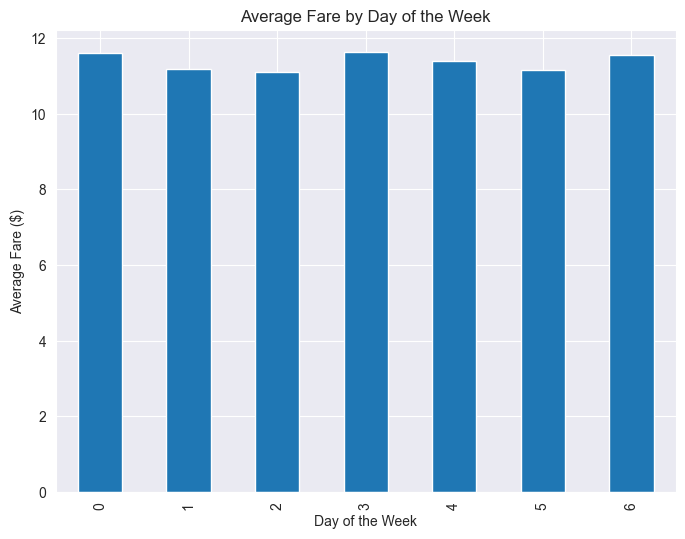

In [5]:
# Visualizing fare amount distribution
plt.figure(figsize=(8, 6))
sns.histplot(data['fare_amount'], bins=30, kde=True)
plt.title("Distribution of Fare Amount")
plt.xlabel("Fare Amount ($)")
plt.show()

# Visualizing distance vs fare
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['distance_km'], y=data['fare_amount'])
plt.title("Fare Amount vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Fare Amount ($)")
plt.show()

# Average fare by day of the week
average_fare_weekday = data.groupby('pickup_weekday')['fare_amount'].mean()
average_fare_weekday.plot(kind='bar', figsize=(8, 6))
plt.title("Average Fare by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Fare ($)")
plt.show()


In [6]:
# Features and target variable
X = data[['distance_km', 'pickup_hour', 'pickup_weekday', 'pickup_month', 'passenger_count']]
y = data['fare_amount']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Compare model performance
print("Linear Regression Performance:")
print(f"MAE: {mean_absolute_error(y_test, lr_predictions):.2f}")
print(f"RMSE: {mean_squared_error(y_test, lr_predictions, squared=False):.2f}")
print(f"R²: {r2_score(y_test, lr_predictions):.2f}")

print("\nXGBoost Performance:")
print(f"MAE: {mean_absolute_error(y_test, xgb_predictions):.2f}")
print(f"RMSE: {mean_squared_error(y_test, xgb_predictions, squared=False):.2f}")
print(f"R²: {r2_score(y_test, xgb_predictions):.2f}")


Linear Regression Performance:
MAE: 3.47
RMSE: 7.35
R²: 0.44

XGBoost Performance:
MAE: 2.37
RMSE: 4.92
R²: 0.75


C:\Users\viraj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\viraj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [7]:
# Evaluate XGBoost on additional metrics
mae = mean_absolute_error(y_test, xgb_predictions)
rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
r2 = r2_score(y_test, xgb_predictions)

print(f"Evaluation Metrics for XGBoost:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")


Evaluation Metrics for XGBoost:
Mean Absolute Error (MAE): 2.37
Root Mean Squared Error (RMSE): 4.92
R-squared (R²): 0.75


C:\Users\viraj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
